In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek

In [5]:
class MITBIHDataset:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.num_classes = None

    
    def load_data(self):
        # Load CSV files
        self.train_data = pd.read_csv(self.train_path, header=None)
        self.test_data = pd.read_csv(self.test_path, header=None)

    
    def preprocess_data(self):
        # Load raw data
        X_train_full, y_train_full = self.train_data.iloc[:, :-1].values, self.train_data.iloc[:, -1].values
        X_test, y_test = self.test_data.iloc[:, :-1].values, self.test_data.iloc[:, -1].values

        # Initial train/val split (before resampling)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, 
            test_size=0.2, 
            random_state=42,
            stratify=y_train_full  # Maintain class distribution in split
        )

        print(f"Train Shape Before Resampling: {X_train.shape}")
        # Apply SMOTE + Tomek Links to training data only
        smote_tomek = SMOTETomek(random_state=42)
        X_res, y_res = smote_tomek.fit_resample(X_train, y_train)
        print(f"Train Shape After Resampling: {X_res.shape}")

        # Normalization after resampling
        scaler = StandardScaler()
        X_res = scaler.fit_transform(X_res)  # Fit only on resampled training data
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Reshape for CNN-LSTM
        X_res = X_res.reshape((X_res.shape[0], X_res.shape[1], 1))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Compute class weights from ORIGINAL distribution
        class_weights = compute_class_weight(
            'balanced', 
            classes=np.unique(y_train_full), 
            y=y_train_full
        )
        class_weights = dict(zip(np.unique(y_train_full), class_weights))

        # Convert labels to categorical
        self.num_classes = len(np.unique(y_train_full))
        y_res = to_categorical(y_res, num_classes=self.num_classes)
        y_val = to_categorical(y_val, num_classes=self.num_classes)
        y_test = to_categorical(y_test, num_classes=self.num_classes)

        return X_res, y_res, X_val, y_val, X_test, y_test, class_weights

In [6]:
class ECGRNNModel:
    def __init__(self, input_shape, num_classes, learning_rate=1e-3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.model = self.build_model()
        self.model.summary()  # Print model architecture

    
    def build_model(self):
        model = Sequential()

        # Input layer
        model.add(Input(shape=self.input_shape))  

        # CNN layers for feature extraction
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))

        # Bidirectional LSTM for sequence modeling
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(64)))

        # Fully connected layers
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(self.num_classes, activation='softmax'))

        # Compile the model
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model

    
    def train(self, X_train, y_train, X_val, y_val, class_weights, epochs=50, batch_size=64):
        # Set up EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model with early stopping
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                       validation_data=(X_val, y_val), #class_weight=class_weights,
                       callbacks=[early_stopping])


    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Compute classification report
        report = classification_report(y_true, y_pred_classes, digits=4)

        print("Test Classification Report:\n")
        print(report)

        # Save the report to a file
        with open("classification_report.txt", "w") as f:
            f.write(report)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_true, y_pred_classes)
        print("Confusion Matrix:\n")
        print(conf_matrix)

        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(self.num_classes), yticklabels=np.arange(self.num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        return report

Train Shape Before Resampling: (70043, 187)
Train Shape After Resampling: (289881, 187)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 185, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 92, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 92, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 90, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 45, 128)             │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 45, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          12,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,133 (1.02 MB)

 Trainable params: 267,133 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 90s 18ms/step - accuracy: 0.8349 - loss: 0.4427 - val_accuracy: 0.9292 - val_loss: 0.2016
Epoch 2/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9521 - loss: 0.1358 - val_accuracy: 0.9462 - val_loss: 0.1460
Epoch 3/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9670 - loss: 0.0940 - val_accuracy: 0.9662 - val_loss: 0.1021
Epoch 4/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9744 - loss: 0.0750 - val_accuracy: 0.9559 - val_loss: 0.1228
Epoch 5/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9787 - loss: 0.0625 - val_accuracy: 0.9644 - val_loss: 0.1069
Epoch 6/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.9818 - loss: 0.0543 - val_accuracy: 0.9599 - val_loss: 0.1193
Epoch 7/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9833 - loss: 0.0489 - val_accuracy: 0.9665 - val_loss: 0.1074
Epoch 8/60
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9841 -

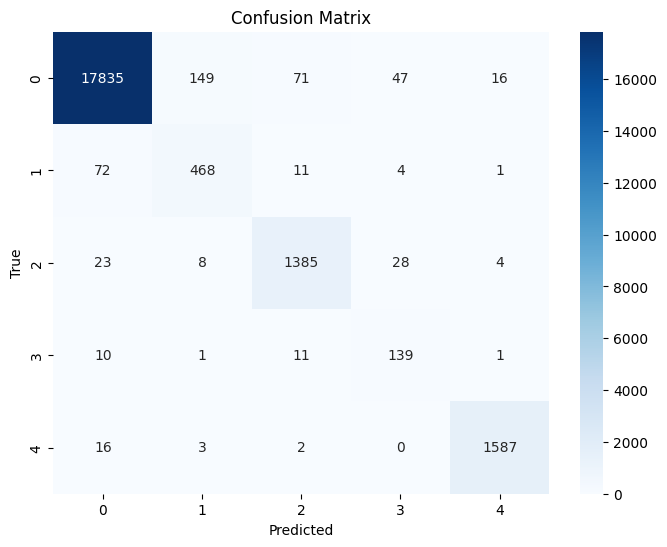

In [7]:
if __name__ == "__main__":
    dataset = MITBIHDataset(train_path='/kaggle/input/mit-bih-dataset/mitbih_train.csv',
                            test_path='/kaggle/input/mit-bih-dataset/mitbih_test.csv')
    dataset.load_data()
    X_train, y_train, X_val, y_val, X_test, y_test, class_weights = dataset.preprocess_data()

    model = ECGRNNModel(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=dataset.num_classes)
    model.train(X_train, y_train, X_val, y_val, class_weights, epochs=60, batch_size=64)

    report = model.evaluate(X_test, y_test)